# Simulation of an Unsteady State Blending Tank

## Process Model

The following model has been developed for a blending tank. Stream 1 consists of a process recycle stream with mass flow $w_1$ and containing a key component with mass fraction $x_1$. Typical values for $w_1$ and $x_1$ are 500 kg/min and 0.4, respectively, but either value may change due to process disturbances. Stream 2 has a mass fraction $x_2$ = 0.75 and mass flow $w_2$, and is combined with stream 1 in a well-mixed blending tank. The resulting stream is drained from the bottom of the blending tank. The process requires the mixed stream to have a mass fraction $x = 0.5$.

Assuming the tank is well-mixed and the streams have a constant density $\rho$ = 900 kg/m**3, the unsteady model is given by

\begin{align*}
\frac{dV}{dt} & = \frac{1}{\rho}(w_1 + w_2 - w)\\
\frac{dx}{dt} & = \frac{1}{\rho V}(w_1 (x_1 - x) + w_2 (x_2 - x))
\end{align*}

where $V$ is the tank volume. The target value for $V$ is 2 cubic meters. The tank volume must never exceed 4 cubic meters, and must never fall below 0.

In [ ]:
# initializations
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

## Nominal Parameter Values

In [91]:
# These initial values correspond to a nominal steady state
V = 2.0           # tank volume, m**3
rho = 900.0       # density, kg/m**3

# stream 1
w1  = 500.0       # nominal flow of stream 1, kg/min
x1 = 0.4          # nominal composition of stream 1, mass fraction

# stream 2
w2  = 200.0       # nominal flow of stream 2, kg/min
x2 = 0.75         # nominal composition of stream 2, mass fraction

# stream 3 -- corresponding steady state values
w = 700.0         # nominal flow of the outlet stream, kg/min
x  = 0.5          # nominal composition of the outlet stream, mass fraction

## Model Fuctions

The next cell defines a Python function to evaluate the right-hand-side of the differential equations. Details on the required function are given in the [documentation for `odeint`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html).

In [108]:
def blending_tank(y, t):
    """
    y is a 2 element list containing values for V and x
    t is the current time
    """
    V, x = y                                   # unpack list of dependent variables
    dVdt = (w1 + w2 - w)/rho                   # dV/dt
    dxdt = (w1*(x1 - x) + w2*(x2 - x))/(rho*V) # dx/dt
    return [dVdt, dxdt]                        # return list of derivatives

## Simulation Study 1: Start Up

For the first simulation we will assume the initial composition in the blending tank is $x = 0$. 

In [109]:
# define time steps at which to compute values of the solution
tstart = 0
tstop = 40
nsteps = 101
t = np.linspace(tstart, tstop, nsteps)

# initial conditions
Vinitial = 2
xinitial = 0
ic = [Vinitial, xinitial]

# compute solution
soln = odeint(blendingtanks, ic, t)

We create a utility function to plot the data that we can reuse for additional simulation studies.

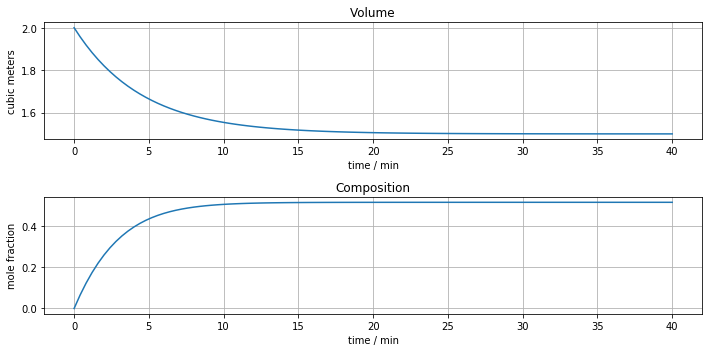

In [110]:
# plotting
def plot(t, soln):
    # the solution consists of a list of data points. Each data point is 
    # 2 element list, the first value is V, the second is x. To extract
    V = soln[:, 0]
    x = soln[:, 1]
    
    plt.figure(figsize=(10,5))
    plt.subplot(2,1,1)
    plt.plot(t, V)
    plt.title('Volume')
    plt.xlabel('time / min')
    plt.ylabel('cubic meters')
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(t, x)
    plt.title('Composition')
    plt.xlabel('time / min')
    plt.ylabel('mole fraction')
    plt.grid()

    plt.tight_layout()
    
plot(t, soln)

## Simulation Study 2: Change in Mass Flowrate $w_1$

Here we assume the blending tank is initially at steady-state, and then inlet mass flowrate $w_1$ falls from 500 kg/min to 400 kg/min. If no other parameter is changed, what happens?

### Steady-State Parameter Values

In [111]:
# These initial values correspond to a nominal steady state
V = 2.0           # tank volume, m**3
rho = 900.0       # density, kg/m**3

# stream 1
w1  = 500.0       # nominal flow of stream 1, kg/min
x1 = 0.4          # nominal composition of stream 1, mass fraction

# stream 2
w2  = 200.0       # nominal flow of stream 2, kg/min
x2 = 0.75         # nominal composition of stream 2, mass fraction

# stream 3 -- corresponding steady state values
w = 700.0         # nominal flow of the outlet stream, kg/min
x  = 0.5          # nominal composition of the outlet stream, mass fraction

Change $w_1$ from 500 kg/min to 400 kg/min

In [112]:
w1 = 400.0

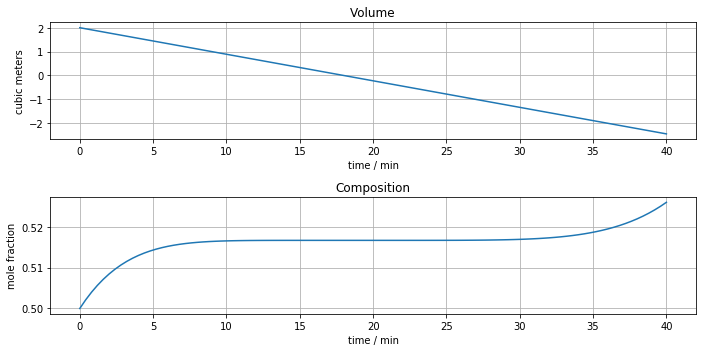

In [114]:
# define time steps at which to compute values of the solution
tstart = 0
tstop = 40
nsteps = 101
t = np.linspace(tstart, tstop, nsteps)

# initial conditions
Vinitial = V
xinitial = x
ic = [Vinitial, xinitial]

# compute solution
soln = odeint(blending_tank, ic, t)
plot(t, soln)

### Results

The result of changing $w_1$ from 500 kg/min to 400 kg/min is for the blending tank to slowly run dry, finally emptying out at about 18 min. The outlet composition rises from a mole fracton of 0.5 to about 0.517 over the same period.

## Simulation Study 3: Level Controller

The previous simulation shows that the blending eventually runs dry if the inlet flowrate $w_1$ decreases and there is no change in any other parameter value. This would be a bad thing to happen in an industrial setting. So the question is whether we can add some additional logic to the model (i.e., a controller) that will avoid this undesirable outcome.

For example, let's consider a level controller of the form

$$w = \bar{w} - K_c (V_{sp} - V)$$

where $w$ is the outlet flow of the blending tank. The idea is that the outlet flow is increased if the measured volume $V$ is less than a **setpoint** value $V_{sp}$, or increased if $V$ is greater than $V_{sp}$. The value $\bar{w}$ is a nominal value of the outlet flowrate. The term $-K_c(V_{sp} - V)$ is compensating action designed to mitigate the impact of disturbances to the input parameters. $K_c$ is a coefficient that we'll determine by simulation.

### Modified model

In [116]:
def blending_tank_level_control(y, t):
    """
    y is a 2 element list containing values for V and x
    t is the current time
    """
    V, x = y                                   # unpack list of dependent variables
    w = w_bar - Kc*(Vsp - V)                   # level control rule
    dVdt = (w1 + w2 - w)/rho                   # dV/dt
    dxdt = (w1*(x1 - x) + w2*(x2 - x))/(rho*V) # dx/dt
    return [dVdt, dxdt]                        # return list of derivatives

### Steady State Parameter Values

In [117]:
# These initial values correspond to a nominal steady state
V = 2.0           # tank volume, m**3
rho = 900.0       # density, kg/m**3

# stream 1
w1  = 500.0       # nominal flow of stream 1, kg/min
x1 = 0.4          # nominal composition of stream 1, mass fraction

# stream 2
w2  = 200.0       # nominal flow of stream 2, kg/min
x2 = 0.75         # nominal composition of stream 2, mass fraction

# stream 3 -- corresponding steady state values
w = 700.0         # nominal flow of the outlet stream, kg/min
x  = 0.5          # nominal composition of the outlet stream, mass fraction

### Control Parameters

In [118]:
w1 = 400          # inlet disturbance
w_bar = w         # control parameter
Kc = 100          # control gain
Vsp = 2           # volume setpoint

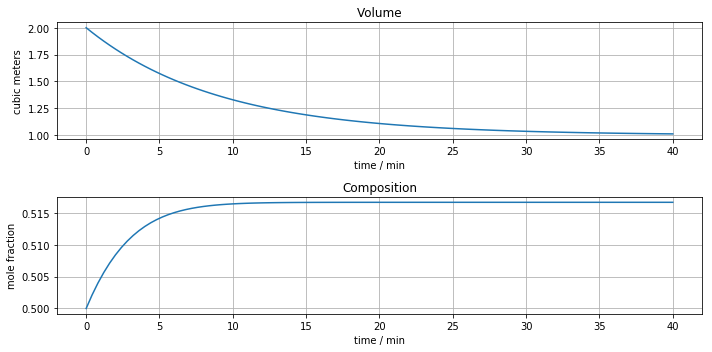

In [119]:
# define time steps at which to compute values of the solution
tstart = 0
tstop = 40
nsteps = 101
t = np.linspace(tstart, tstop, nsteps)

# initial conditions
Vinitial = V
xinitial = x
ic = [Vinitial, xinitial]

# compute solution
soln = odeint(blending_tank_level_control, ic, t)
plot(t, soln)

### Results

The simulation of level control shows that it does keep the tank from going empty. But the tank also does not return to the original volume of 2 cubic meters, thus there is room for improvement. Furthermore, the outlet composition increases to 0.517 with no significant correction.

## Exercises

1. Open and save a copy of this notebook on your laptop. Then create a new section below entitled 'Simulation Study 4: Effects of Control Gain'.  Run simulations for at least 4 additional values of $K_c$ and note the results. What is the impact of larger values of $K_c$ on (a) final volume, (b) the final composition, and (c) how fast the controlled system reaches steady state?

2. Create a new section below entitled 'Simulation Study 5: Composition Control'.  Starting with the model that includes a level control, add a second controller of the form $$w_2 = \bar{w}_2 + K_{c2}(x_{sp} - x)$$ where $x_{sp}$ is the desired output composition (= 0.5), $\bar{w}_2$ is the nominal value of $w_2$ (i.e., 200), and $K_{c2}$ is a constant that you need to choose. Now repeat the simulation study to see to what extent these two controllers mitigate the impact of the change in $w_1$.